In [70]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [71]:
#Read NN and BMS data
n=3;runid=0;function='tanh' #tanh, leaky_ReLU
realization=0
sigma=0.06
NPAR=10 #10, 20
steps=50000


#Read NN data
train_size=60
file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'

model_d='../data/trained_nns/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)
display(dn)

#Read BMS trace
filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])

,x1,y,rep,noise,y_noise,ymodel
0,-1.95,0.319793,3.0,0.068150,0.387943,0.401020
1,-1.90,0.287270,3.0,0.021849,0.309119,0.335287
2,-1.85,0.255961,3.0,0.035136,0.291097,0.274539
3,-1.80,0.226199,3.0,0.031426,0.257625,0.223472
4,-1.75,0.198275,3.0,0.016897,0.215172,0.185648
...,...,...,...,...,...,...
75,1.80,0.313850,3.0,0.041673,0.355523,1.197607
76,1.85,0.308885,3.0,-0.009865,0.299019,1.193479
77,1.90,0.304060,3.0,0.096769,0.400830,1.187488
78,1.95,0.299390,3.0,0.055626,0.355016,1.179820


In [72]:
#Parameters to read models
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()
y=dn.noise

if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

In [73]:
#Minimum description length model
minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

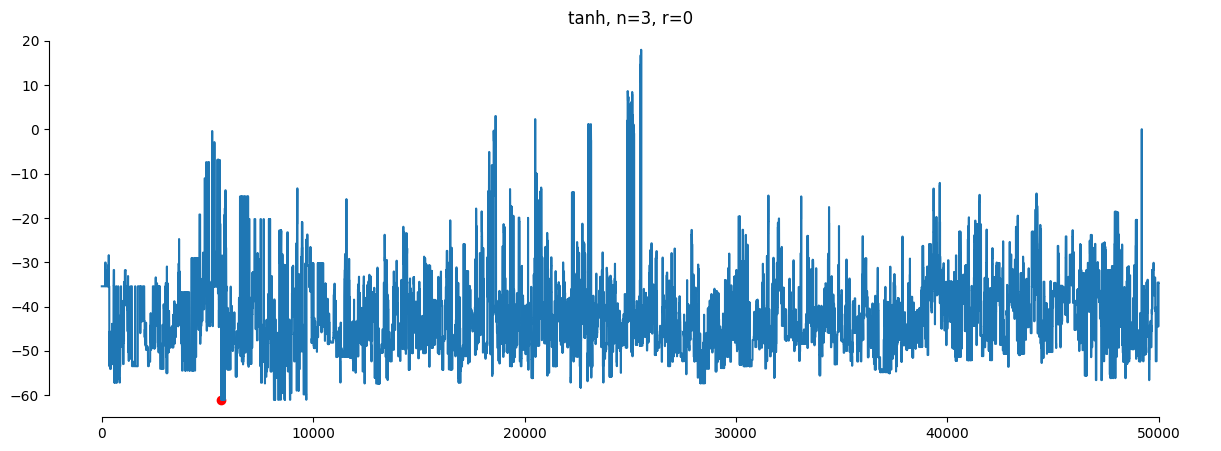

In [74]:
Nini = 00
plt.figure(figsize=(15, 5))

#Define figure size in cm                                                                           
Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                           
plt.title(str(function) + ', ' + 'n=' + str(n) +', r=' + str(realization))
plt.plot(trace.t[trace.t > Nini], trace.H[trace.t > Nini])
plt.scatter(minrow['t'], minH,color='r')
sns.despine(trim=True)

Name_figure='Energy_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

for ext in Extensions:
        plt.savefig('../results/' + Name_figure + ext,dpi=300)

 
plt.show()

,x1,y,rep,noise,y_noise,ymodel
0,-1.95,0.319793,3.0,0.068150,0.387943,0.401020
1,-1.90,0.287270,3.0,0.021849,0.309119,0.335287
2,-1.85,0.255961,3.0,0.035136,0.291097,0.274539
3,-1.80,0.226199,3.0,0.031426,0.257625,0.223472
4,-1.75,0.198275,3.0,0.016897,0.215172,0.185648
...,...,...,...,...,...,...
75,1.80,0.313850,3.0,0.041673,0.355523,1.197607
76,1.85,0.308885,3.0,-0.009865,0.299019,1.193479
77,1.90,0.304060,3.0,0.096769,0.400830,1.187488
78,1.95,0.299390,3.0,0.055626,0.355016,1.179820


60
0.9999999999999822


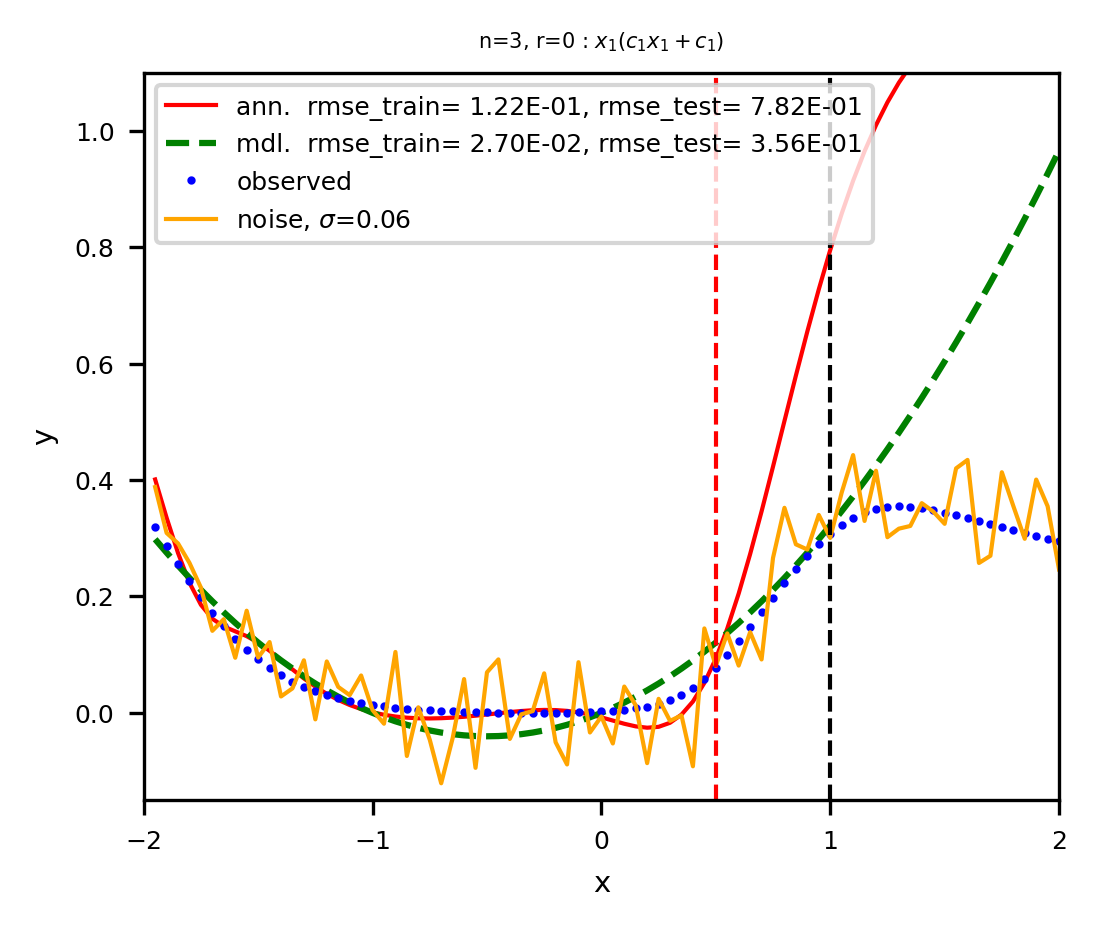

In [75]:
#Plot
train_size_ann=50
validation_border=dn.loc[train_size_ann-1]['x1']

train_border=dn.loc[train_size-1]['x1']
display(dn)
print(train_size)
print(train_border)

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)

rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])

rmse_mdl=root_mean_squared_error(dplot.ybms,dn.y)
rmse_mdl_train=root_mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
rmse_mdl_test =root_mean_squared_error(dplot.loc[train_size-1:]['ybms'],dn.loc[train_size-1:]['y'])

 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test)) 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_mdl_train, rmse_mdl_test)) 
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed') 
plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label='noise, ' + r'$\sigma$=' + str(sigma) ) 
                                                                                

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

#plt.xlim(-4.5,4.5);plt.ylim(-1.1,1.5) 
plt.xlim(-2,2);plt.ylim(-0.15,1.1)  

Name_figure='Prediction_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

In [76]:
#Interpolation/extrapolation

In [77]:
#Read high resolution data
resolution=0.01
filename_high_res='../data/NN_' + str(function) + '_sigma_' + str(sigma) + '_r_0_res_' + str(resolution) + '_data.csv'
dhr=pd.read_csv(filename_high_res,index_col=0)

dhr=dhr[dhr['rep']==n]
dnhr=dhr[(dhr['x1']>=-2.0) & (dhr['x1']<=2.0)]
dnhr=dnhr.reset_index(drop=True)

x = dnhr[[c for c in VARS]].copy()
y = dnhr.noise

interpol_size=dnhr.index[ (dnhr['x1']<=1.00) & (dnhr['x1']>0.99)][0]

display(train_border_new)
display(dnhr)

299

,x1,y,rep,noise,y_noise
0,-1.99,0.346442,3.0,0.096289,0.442731
1,-1.98,0.339739,3.0,-0.045134,0.294605
2,-1.97,0.333061,3.0,-0.060723,0.272338
3,-1.96,0.326411,3.0,0.038704,0.365116
4,-1.95,0.319793,3.0,0.019353,0.339145
...,...,...,...,...,...
395,1.96,0.298475,3.0,-0.126367,0.172108
396,1.97,0.297566,3.0,-0.083172,0.214394
397,1.98,0.296663,3.0,-0.101321,0.195343
398,1.99,0.295768,3.0,0.037773,0.333541


,x1,y,rep,noise,y_noise,ybms
0,-1.99,0.346442,3.0,0.096289,0.442731,0.317225
1,-1.98,0.339739,3.0,-0.045134,0.294605,0.312443
2,-1.97,0.333061,3.0,-0.060723,0.272338,0.307693
3,-1.96,0.326411,3.0,0.038704,0.365116,0.302975
4,-1.95,0.319793,3.0,0.019353,0.339145,0.298289
...,...,...,...,...,...,...
395,1.96,0.298475,3.0,-0.126367,0.172108,0.934173
396,1.97,0.297566,3.0,-0.083172,0.214394,0.942111
397,1.98,0.296663,3.0,-0.101321,0.195343,0.950082
398,1.99,0.295768,3.0,0.037773,0.333541,0.958085


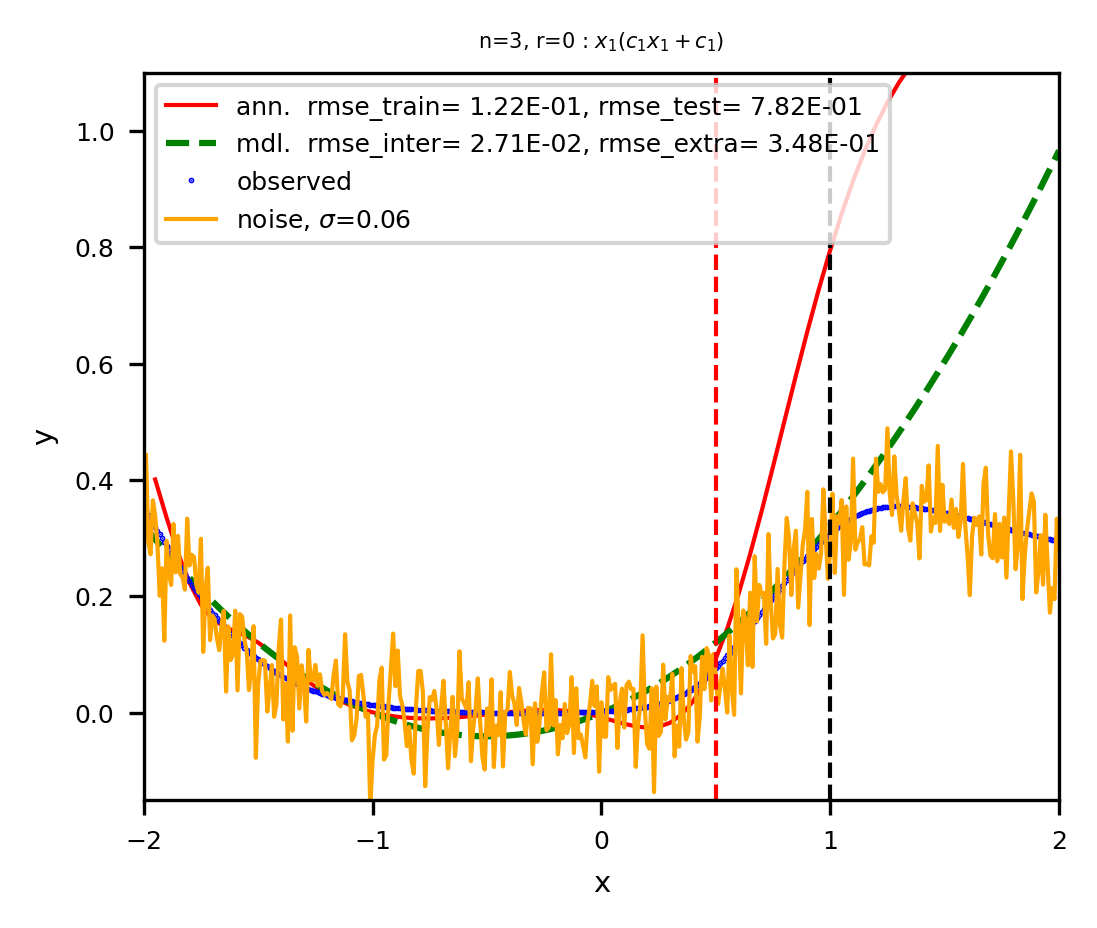

In [78]:
#BMS predictions
dinterpol=deepcopy(dnhr)
dinterpol['ybms']=t.predict(x)
display(dinterpol)


rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])

rmse_mdl=root_mean_squared_error(dinterpol.ybms,dinterpol.y)
rmse_mdl_inter=root_mean_squared_error(dinterpol.loc[:interpol_size-1]['ybms'],dinterpol.loc[:interpol_size-1]['y'])
rmse_mdl_extra =root_mean_squared_error(dinterpol.loc[interpol_size-1:]['ybms'],dinterpol.loc[interpol_size-1:]['y'])
 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test)) 
plt.plot(dinterpol.x1, dinterpol.ybms, color='green', linestyle='--', label='mdl.  rmse_inter= %.2E, rmse_extra= %.2E' % ( rmse_mdl_inter, rmse_mdl_extra))
plt.plot(dinterpol['x1'], dinterpol['y'],'.', markersize=0.75, color='blue',label='observed')
plt.plot(dinterpol['x1'], dinterpol['y_noise'],linewidth=line_w, markersize=2, color='orange',label='noise, ' + r'$\sigma$=' + str(sigma))
                                                                                

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

#plt.xlim(-4.5,4.5);plt.ylim(-1.1,1.5) 
plt.xlim(-2,2);plt.ylim(-0.15,1.1)  

Name_figure='Interpolation_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

In [60]:
import pyrenn
#try to load nn
weights='../data/trained_nns/' + 'NN_weights_no_overfit_' + function + '_sigma_\
' + str(sigma) + '_rep_' + str(n) + '_r_' + str(realization) + '.csv'
test_nn = pyrenn.loadNN(weights)

Exception ignored in: <_io.FileIO name='../data/trained_nns/NN_weights_no_overfit_tanh_sigma_0.06_rep_0_r_0.csv' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/home/scobol/.local/lib/python3.10/site-packages/pyrenn.py", line 949, in loadNN
    data= list(csv.reader(open(filename,"r")))


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations